In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TreebankWordTokenizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
from recommender_functions import get_sparse,movie_recommendations,book_recommendations,get_vectors
import gensim.downloader as api
from gensim.test.utils import datapath

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sibongiletoure/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
movie_book_df = pd.read_pickle("sample_book_movie_df.pkl")

In [3]:
movie_book_df

title title_id/book_isbn  \
0                                    Summer Stock          tt0043012   
1                               In a Lonely Place          tt0042593   
2                                    Sunset Blvd.          tt0043014   
3                                      Cinderella          tt0042332   
4                                   All About Eve          tt0042192   
...                                           ...                ...   
4545                               archer's voice                NaN   
4546  the complete anne of green gables boxed set        76783609419   
4547                      the complete persepolis        9.78038E+12   
4548                   the man in the high castle        9.78068E+12   
4549                       the accidental tourist        9.78035E+12   

                                                 genres      release_date  \
0                                      Musical, Romance    31 August 1950   
1                             Drama, Film-Noir, Mystery       17 May 1950   
2                                      Drama, Film-Noir    10 August 1950   
3                            Animation, Family, Fantasy  15 February 1950   
4                                                 Drama   13 October 1950   
...                                                 ...               ...   
4545  Romance,New Adult,Contemporary,Romance,Contemp...               NaN   
4546  Classics,Fiction,Young Adult,Childrens,Histori...               NaN   
4547  Sequential Art,Graphic Novels,Sequential Art,C...               NaN   
4548  Science Fiction,Fiction,Science Fiction,Altern...               NaN   
4549      Fiction,Contemporary,Literary Fiction,Romance               NaN   

                                         plot/book_desc year_of_release  \
0     As a favor to her actress sister Abigail, New ...            1950   
1     Dixon Steele is a Hollywood screenwriter who h...            1950   
2     Joe Gillis is a struggling hack B-movie Hollyw...            1950   
3     In a far away, long ago kingdom, Cinderella is...            1950   
4     Stage star Margo Channing is friend to playwri...            1950   
...                                                 ...             ...   
4545  A New York Times, USA Today, and Wall Street J...             NaN   
4546  Favorites for nearly 100 years, these classic ...             NaN   
4547  Here, in one volume: Marjane Satrapi's best-se...             NaN   
4548  It's America in 1962. Slavery is legal once ag...             NaN   
4549  Macon Leary is a travel writer who hates both ...             NaN   

                                        author/director isBook isMovie  \
0                                       Charles Walters      0       1   
1                                          Nicholas Ray      0       1   
2                                          Billy Wilder      0       1   
3       Clyde Geronimi, Wilfred Jackson, Hamilton Luske      0       1   
4                                  Joseph L. Mankiewicz      0       1   
...                                                 ...    ...     ...   
4545                                       Mia Sheridan      1       0   
4546                                    L.M. Montgomery      1       0   
4547  Marjane Satrapi,Mattias Ripa,Blake Ferris,Anja...      1       0   
4548                                     Philip K. Dick      1       0   
4549                                         Anne Tyler      1       0   

       index book/movie  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
...      ...        ...  
4545  1000.0        NaN  
4546  1001.0        NaN  
4547  1002.0        NaN  
4548  1003.0        NaN  
4549  1004.0        NaN  

[4550 rows x 11 columns]

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

class NLPPipe:
   
    def __init__(self, vectorizer= TfidfVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.fit_transform(clean_text)

In [5]:
def clean_text(text, tokenizer, lemmatizer):
        cities =  {"New York":"New_York",
        'Los Angeles':'Los_Angeles',
        'Hong Kong':'Hong_Kong',
        'San Fransisco':'San_Fransisco',
        'New Delhi':'New_Delhi',
        'Sao Paulo':'Sao_Paulo',
         'Mexico City':'Mexico_City'}
        text=text.str.replace(r'\d+','')
        text=text.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
        cleaned_text = []
        for post in text:
            for key in cities.keys():
                if key in post:
                    post = post.replace(key, cities[key])
            post = post.replace('World War II','WWII')
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if lemmatizer:
                    low_word = lemmatizer.lemmatize(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text

In [6]:
stop_words = nltk.corpus.stopwords.words('english')
languages = ['arabic','danish','dutch','english','finnish','french','german','greek','hungarian',
 'italian','kazakh', 'norwegian','portuguese','romanian','russian','slovene','spanish','swedish',
 'turkish']
for l in languages:
    stop_words.extend(nltk.corpus.stopwords.words(l))
new_stopwords = ['want','ha','ca','ago','know','may','would','go'\
               ,'wa','also','old','year','two','one',\
               'film', 'movie', 'feature', 'director', 'short', 'filmmaker', 'character', 'star', 'comedy', 'based',\
                'story', 'based', 'tells', 'true', 'directed','find','way','must','meet',\
               'de', 'la', 'un', 'su', 'en', 'el', 'que', 'una', 'se', 'le','three',
               'time', 'day', 'take', 'people', 'make', 'first', 'come', 'work', 'place', 'night',\
               'yearold','dy','little','named','back','doe','tell','get','hi','thi','becomes',
               'book', 'novel', 'reader', 'author', 'series', 'read', 'written', 'history', 'edition',\
                'edition',  'bestselling', 'reader','published','set', 'text', 'drama', 'classic','literary','bestseller','academy','award']
stop_words.extend(new_stopwords)
stop_words = set(stop_words) 

In [7]:
corpus = movie_book_df['plot/book_desc']

In [8]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [9]:
cos_mat = get_sparse(tf_result)

In [10]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'the lord of the rings')
recommendation

[2554, 2665, 2606, 774, 15]


(2554    The Lord of the Rings: The Fellowship of the Ring
 2665        The Lord of the Rings: The Return of the King
 2606                The Lord of the Rings: The Two Towers
 774                                                 Help!
 15                                                 Sierra
 Name: title, dtype: object,
 [2554, 2665, 2606, 774, 15],
 3943)

In [11]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'harry potter and the order of the phoenix')
recommendation

[2553, 2758, 3085, 2867, 2604]


(2553           Harry Potter and the Sorcerer's Stone
 2758             Harry Potter and the Goblet of Fire
 3085    Harry Potter and the Deathly Hallows: Part 2
 2867       Harry Potter and the Order of the Phoenix
 2604         Harry Potter and the Chamber of Secrets
 Name: title, dtype: object,
 [2553, 2758, 3085, 2867, 2604],
 3551)

In [12]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'gone with the wind')
recommendation

[260, 3472, 2195, 566, 3344]


(260     The Seven Year Itch
 3472           Little Women
 2195             Gettysburg
 566         One, Two, Three
 3344    Free State of Jones
 Name: title, dtype: object,
 [260, 3472, 2195, 566, 3344],
 3556)

## TFIDF reccomender with different hyperparameters
* The recommender seems to work pretty well so far giving me civil war movies for Gone with the wind and a Harry potter movie for harry potter but I want to see if adding a min df makes an improvement

In [13]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [14]:
# Get a sparse matrix based on cos similarities
cos_mat = get_sparse(tf_result)

In [15]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'the lord of the rings')
recommendation

[2554, 2665, 774, 15, 2606]


(2554    The Lord of the Rings: The Fellowship of the Ring
 2665        The Lord of the Rings: The Return of the King
 774                                                 Help!
 15                                                 Sierra
 2606                The Lord of the Rings: The Two Towers
 Name: title, dtype: object,
 [2554, 2665, 774, 15, 2606],
 3943)

In [16]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'harry potter and the order of the phoenix')
recommendation

[2788, 2553, 705, 254, 2934]


(2788                      Kiss Kiss Bang Bang
 2553    Harry Potter and the Sorcerer's Stone
 705                                Dear Heart
 254                   The Night of the Hunter
 2934                       Burn After Reading
 Name: title, dtype: object,
 [2788, 2553, 705, 254, 2934],
 3551)

In [17]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'gone with the wind')
recommendation

[1066, 7, 824, 2859, 1025]


(1066           The Beguiled
 7         Stars in My Crown
 824     Au Hasard Balthazar
 2859    Mother of the Dunes
 1025                 Chisum
 Name: title, dtype: object,
 [1066, 7, 824, 2859, 1025],
 3556)

## TFIDF with Max_df
* The recommender is ok with the min_df but does worse on book series like Harry potter 

In [18]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [19]:
cos_mat = get_sparse(tf_result)

In [20]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'the lord of the rings')
recommendation

[2554, 2665, 2606, 774, 15]


(2554    The Lord of the Rings: The Fellowship of the Ring
 2665        The Lord of the Rings: The Return of the King
 2606                The Lord of the Rings: The Two Towers
 774                                                 Help!
 15                                                 Sierra
 Name: title, dtype: object,
 [2554, 2665, 2606, 774, 15],
 3943)

In [21]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'harry potter and the order of the phoenix')
recommendation

[2553, 2758, 3085, 2867, 2604]


(2553           Harry Potter and the Sorcerer's Stone
 2758             Harry Potter and the Goblet of Fire
 3085    Harry Potter and the Deathly Hallows: Part 2
 2867       Harry Potter and the Order of the Phoenix
 2604         Harry Potter and the Chamber of Secrets
 Name: title, dtype: object,
 [2553, 2758, 3085, 2867, 2604],
 3551)

In [22]:
recommendation = movie_recommendations(cos_mat,movie_book_df,'gone with the wind')
recommendation

[260, 3472, 2195, 566, 3344]


(260     The Seven Year Itch
 3472           Little Women
 2195             Gettysburg
 566         One, Two, Three
 3344    Free State of Jones
 Name: title, dtype: object,
 [260, 3472, 2195, 566, 3344],
 3556)

* Max_df and no df gives same recommendations so moving forward I will stick with min df

## Try Word2Vec and see what recommendations it gives

In [23]:
model = api.load('word2vec-google-news-300')

In [24]:
clean_corpus = clean_text(corpus,tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

In [34]:
def vectors(x):

    global word_embeddings
    word_embeddings = []

    # Reading the each book description
    for line in x:
        avgword2vec = None
        count = 0
        for word in line.split():
            #print(word)
            if word in model:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model[word]
                else:
                    avgword2vec = avgword2vec + model[word]

        if avgword2vec is not None:
            avgword2vec = avgword2vec / count

            word_embeddings.append(avgword2vec)


In [36]:
vectors(clean_corpus)

In [37]:
word_embeddings

[array([ 2.21822485e-02,  1.93884503e-02, -4.04709168e-02,  4.93169837e-02,
        -3.55774508e-04,  7.09807221e-03, -8.47755279e-03, -7.41369873e-02,
         8.45596008e-03,  3.31593640e-02,  3.93734360e-03, -1.40704468e-01,
        -4.75613587e-02,  2.17930060e-02, -9.96865332e-02,  9.71714258e-02,
         5.47165796e-02,  6.29841089e-02, -1.95395984e-02, -4.89674695e-02,
        -1.26036154e-02,  3.33958119e-02, -2.55553052e-02, -2.23817639e-02,
         4.33983002e-03, -3.82506172e-03, -9.90424976e-02,  8.65426660e-02,
         1.78729359e-03, -2.65134424e-02, -1.95208862e-02,  7.13132438e-04,
        -5.28996289e-02, -2.04968359e-02,  1.47705078e-02, -2.29929797e-02,
         2.67644916e-02,  2.42194403e-02,  7.99370557e-02,  3.37037854e-02,
         5.80507666e-02, -2.94978302e-02,  8.45326856e-02, -1.32566486e-02,
        -1.00028561e-02, -4.67333533e-02, -7.96341822e-02,  4.61498462e-02,
         6.38406128e-02,  9.90519971e-02, -4.38560639e-03,  2.18648370e-02,
         4.7

In [38]:
word_result = get_sparse(word_embeddings)

In [39]:
recommendation = movie_recommendations(word_result,movie_book_df,'the lord of the rings')
recommendation

[2554, 3192, 2606, 2665, 36]


(2554    The Lord of the Rings: The Fellowship of the Ring
 3192                  The Hobbit: The Desolation of Smaug
 2606                The Lord of the Rings: The Two Towers
 2665        The Lord of the Rings: The Return of the King
 36                                The Flame and the Arrow
 Name: title, dtype: object,
 [2554, 3192, 2606, 2665, 36],
 3943)

In [40]:
recommendation = movie_recommendations(word_result,movie_book_df,'harry potter and the goblet of fire')
recommendation

[2553, 2961, 1269, 141, 645]


(2553     Harry Potter and the Sorcerer's Stone
 2961    Harry Potter and the Half-Blood Prince
 1269                 The Man Who Would Be King
 141                      O. Henry's Full House
 645                                Il Sorpasso
 Name: title, dtype: object,
 [2553, 2961, 1269, 141, 645],
 3656)

In [41]:
recommendation = movie_recommendations(word_result,movie_book_df,'gone with the wind')
recommendation

[2134, 1749]


(2134                Orlando
 1749    Places in the Heart
 Name: title, dtype: object,
 [2134, 1749],
 3556)

In [42]:
recommendation = movie_recommendations(word_result,movie_book_df,'Emma.')
recommendation

[3508, 1731, 532, 3229, 2430]


(3508                  Emma.
 1731    Romancing the Stone
 532       The Fugitive Kind
 3229                Daisy's
 2430    Shakespeare in Love
 Name: title, dtype: object,
 [3508, 1731, 532, 3229, 2430],
 3508)

### Word2Vec gives ok recommendations but for some only has 2 recommendations
* Want to try both methods with a full corpus

In [43]:
book_movie_df = pd.read_pickle("book_movie_df.pkl")

In [44]:
full_corpus = book_movie_df['plot/book_desc']

In [45]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(full_corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [46]:
cos_mat = get_sparse(tf_result)

RuntimeError: nnz of the result is too large

In [ ]:
recommendation = movie_recommendations(word_result,movie_book_df,'the lord of the rings')
recommendation

* nnz to large error will try setting max features to 10000 to see if i get any changes

In [ ]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2),max_features=10000), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(full_corpus)

In [ ]:
cos_mat = get_sparse(tf_result)

* The full corpus seems to large for my recommender will try again with a larger subset of my data

## TFIDF 
* Sample now includes the top 200 movies per year and top 2000 book 

In [68]:
movie_book_df2 = pd.read_pickle('sample_data2.pkl')

In [69]:
corpus = movie_book_df2['plot/book_desc']

* Will see how min_df works with a larger corpus. I predict that the max_df and word2vec will still perform better

In [49]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [50]:
cos_mat = get_sparse(tf_result)

In [51]:
recommendation = movie_recommendations(cos_mat,movie_book_df2,'the lord of the rings')
recommendation

[10204, 1410, 9580, 10615, 3308]


(10204    The Lord of the Rings: The Fellowship of the Ring
 1410                                       Throne of Blood
 9580                                             Annamayya
 10615        The Lord of the Rings: The Return of the King
 3308                                              Daimajin
 Name: title, dtype: object,
 [10204, 1410, 9580, 10615, 3308],
 14593)

In [52]:
recommendation = movie_recommendations(cos_mat,movie_book_df2,'harry potter and the order of the phoenix')
recommendation

[3257, 11038, 10203, 2805, 10121]


(3257                                    Gambit
 11038                      Kiss Kiss Bang Bang
 10203    Harry Potter and the Sorcerer's Stone
 2805                                Dear Heart
 10121              With a Friend Like Harry...
 Name: title, dtype: object,
 [3257, 11038, 10203, 2805, 10121],
 14201)

In [53]:
recommendation = movie_recommendations(cos_mat,movie_book_df2,'gone with the wind')
recommendation

[9111, 3776, 3955, 5548, 4216]


(9111                                     Land and Freedom
 3776                             Täällä Pohjantähden alla
 3955    Il Prof. Dott. Guido Tersilli primario della C...
 5548                             Coz takhle dát si spenát
 4216                                         The Beguiled
 Name: title, dtype: object,
 [9111, 3776, 3955, 5548, 4216],
 14206)

## TFIDF with max_df of 0.5

In [54]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [55]:
cos_mat = get_sparse(tf_result)

In [56]:
recommendation,movie_indices,idx = movie_recommendations(cos_mat,movie_book_df2,'the lord of the rings')
recommendation

[10204, 10406, 10615, 3024, 12450]


10204    The Lord of the Rings: The Fellowship of the Ring
10406                The Lord of the Rings: The Two Towers
10615        The Lord of the Rings: The Return of the King
3024                                                 Help!
12450                    The Hobbit: An Unexpected Journey
Name: title, dtype: object

In [57]:
recommendation = movie_recommendations(cos_mat,movie_book_df2,'harry potter and the order of the phoenix')
recommendation

[10203, 11008, 12235, 10404, 11417]


(10203           Harry Potter and the Sorcerer's Stone
 11008             Harry Potter and the Goblet of Fire
 12235    Harry Potter and the Deathly Hallows: Part 2
 10404         Harry Potter and the Chamber of Secrets
 11417       Harry Potter and the Order of the Phoenix
 Name: title, dtype: object,
 [10203, 11008, 12235, 10404, 11417],
 14201)

In [58]:
recommendation = movie_recommendations(cos_mat,movie_book_df2,'gone with the wind')
recommendation

[6976, 12931, 1010, 7723, 4594]


(6976     When the Tenth Month Comes
 12931         Mr. Peabody & Sherman
 1010            The Seven Year Itch
 7723               The Little Thief
 4594               Georgia, Georgia
 Name: title, dtype: object,
 [6976, 12931, 1010, 7723, 4594],
 14206)

* Will add some word cloud to see what some of the most common words are between the book and the films

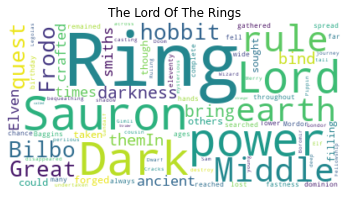

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx]['title'].title())
plt.axis("off")
plt.show();

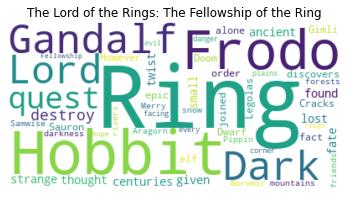

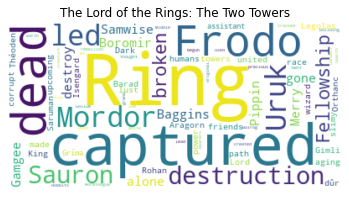

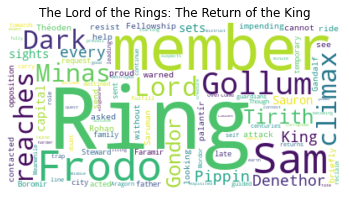

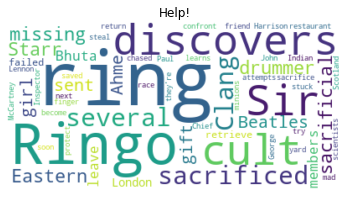

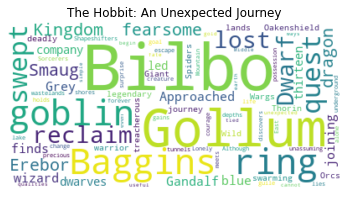

In [60]:
for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

* TFIDF seems to be connecting these through the word ring as well as some of the character names

## Word2Vec

In [61]:
clean_corpus = clean_text(corpus,tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

In [71]:
len(clean_corpus)

16200

In [62]:
vectors(clean_corpus)

In [72]:
len(word_embeddings)

16200

In [63]:
word_results = get_sparse(word_embeddings)

In [64]:
recommendation = movie_recommendations(word_result,movie_book_df,'gone with the wind')
recommendation

[2134, 1749]


(2134                Orlando
 1749    Places in the Heart
 Name: title, dtype: object,
 [2134, 1749],
 3556)

## Try Word2Vec without a sparse matrix

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

In [75]:
def recommendations(title,cosine_similarities):
    
  

    # taking the title and book image link and store in new data frame called books
    movies = movie_book_df2[movie_book_df2['isMovie']==1][['title','author/director','release_date']]
    #books = movie_book_df['title']
    #Reverse mapping of the index
    indices = pd.Series(movie_book_df2.index, index = movie_book_df2['title'])
    print(len(indices))
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores  = [score for score in sim_scores if movie_book_df2.iloc[score[0]]['isMovie']==1]
    sim_scores = sim_scores[1:6]
    print(sim_scores)
    movie_indices = [i[0] for i in sim_scores]
    print(movie_indices)
    recommend = movies.iloc[movie_indices]
    return recommend

In [76]:
recommendation = recommendations('gone with the wind',cosine_similarities)
recommendation

16200
[(8434, 0.8935751), (12509, 0.8911757), (5594, 0.8904434), (10993, 0.8898636), (6849, 0.889675)]
[8434, 12509, 5594, 10993, 6849]


title               author/director       release_date
8434                 Orlando                  Sally Potter   1 September 1992
12509              The Words  Brian Klugman, Lee Sternthal    27 January 2012
5594   Mga bilanggong birhen     Mario O'Hara, Romy Suzara   24 December 1977
10993                  Nyfes            Pantelis Voulgaris  14 September 2004
6849     Places in the Heart                 Robert Benton  11 September 1984

In [78]:
recommendation = recommendations('harry potter and the goblet of fire',cosine_similarities)
recommendation

16200
[(11811, 0.9204625), (5019, 0.918494), (3078, 0.91823107), (441, 0.91544366), (2445, 0.9144143)]
[11811, 5019, 3078, 441, 2445]


title  \
11811  Harry Potter and the Half-Blood Prince   
5019                The Man Who Would Be King   
3078                   The Truth About Spring   
441                     O. Henry's Full House   
2445                              Il Sorpasso   

                                         author/director      release_date  
11811                                        David Yates       6 July 2009  
5019                                         John Huston  27 November 1975  
3078                                      Richard Thorpe     31 March 1965  
441    Henry Hathaway, Howard Hawks, Henry King, Henr...     7 August 1952  
2445                                           Dino Risi   5 December 1962

In [79]:
recommendation = recommendations('the lord of the rings',cosine_similarities)
recommendation

16200
[(12450, 0.9184871), (12642, 0.91396046), (10406, 0.9135915), (10615, 0.9118732), (36, 0.9062829)]
[12450, 12642, 10406, 10615, 36]


title   author/director  \
12450              The Hobbit: An Unexpected Journey     Peter Jackson   
12642            The Hobbit: The Desolation of Smaug     Peter Jackson   
10406          The Lord of the Rings: The Two Towers     Peter Jackson   
10615  The Lord of the Rings: The Return of the King     Peter Jackson   
36                           The Flame and the Arrow  Jacques Tourneur   

           release_date  
12450  28 November 2012  
12642   2 December 2013  
10406   5 December 2002  
10615   1 December 2003  
36          7 July 1950

In [81]:
recommendation = recommendations('gone with the wind',cosine_similarities)
recommendation

16200
[(8434, 0.8935751), (12509, 0.8911757), (5594, 0.8904434), (10993, 0.8898636), (6849, 0.889675)]
[8434, 12509, 5594, 10993, 6849]


title               author/director       release_date
8434                 Orlando                  Sally Potter   1 September 1992
12509              The Words  Brian Klugman, Lee Sternthal    27 January 2012
5594   Mga bilanggong birhen     Mario O'Hara, Romy Suzara   24 December 1977
10993                  Nyfes            Pantelis Voulgaris  14 September 2004
6849     Places in the Heart                 Robert Benton  11 September 1984

In [83]:
recommendation = recommendations('little women',cosine_similarities)
recommendation

16200
[(11927, 0.9313857), (9045, 0.92988145), (6436, 0.9263113), (1606, 0.9242244), (13212, 0.9241944)]
[11927, 9045, 6436, 1606, 13212]


title                     author/director  \
11927           Coco Before Chanel                       Anne Fontaine   
9045             A Little Princess                      Alfonso Cuarón   
6436   The World According to Garp                     George Roy Hill   
1606                          Gigi  Vincente Minnelli, Charles Walters   
13212                    Brimstone                    Martin Koolhoven   

           release_date  
11927      6 April 2009  
9045        10 May 1995  
6436       14 July 1982  
1606        15 May 1958  
13212  3 September 2016

* Due to more obvious connections between the films and books for this recommender I will go with TFIDF with a max_df of 0.5
* I will try some dimensionality reduction with TruncatedSVD before adding to my streamlit application

In [86]:
tf_result.shape

(16200, 73314)

In [84]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'арбаң', 'арсалаң', 'батыр', 'бүгжең', 'бұтыр', 'далаң', 'ербелең', 'жалт', 'жұлт', 'күңгір', 'митың', 'онан', 'паһ', 'салаң', 'сұлаң', 'сұрт', 'тарбаң', 'тыржың', 'тұрс', 'шұңқ', 'ыржың', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'әттеген', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


## TFIDF

In [85]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [87]:
cos_mat = get_sparse(tf_result)

In [88]:
recommendation,movie_indices,idx = movie_recommendations(cos_mat,movie_book_df2,'the lord of the rings')
recommendation

[10204, 10615, 10406, 3024, 15]


10204    The Lord of the Rings: The Fellowship of the Ring
10615        The Lord of the Rings: The Return of the King
10406                The Lord of the Rings: The Two Towers
3024                                                 Help!
15                                                  Sierra
Name: title, dtype: object

In [89]:
recommendation = movie_recommendations(cos_mat,movie_book_df2,'harry potter and the order of the phoenix')
recommendation

[10203, 11008, 12235, 11417, 10404]


(10203           Harry Potter and the Sorcerer's Stone
 11008             Harry Potter and the Goblet of Fire
 12235    Harry Potter and the Deathly Hallows: Part 2
 11417       Harry Potter and the Order of the Phoenix
 10404         Harry Potter and the Chamber of Secrets
 Name: title, dtype: object,
 [10203, 11008, 12235, 11417, 10404],
 14201)

In [94]:
recommendation,movie_indices,idx = movie_recommendations(cos_mat,movie_book_df2,'gone with the wind')
recommendation

[4594, 1010, 12931, 10491, 7459]


4594                    Georgia, Georgia
1010                 The Seven Year Itch
12931              Mr. Peabody & Sherman
10491    The Importance of Being Earnest
7459                      House of Games
Name: title, dtype: object

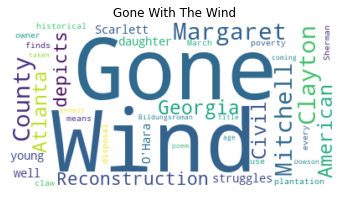

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[idx]['plot/book_desc'])
plt.imshow(wc, interpolation='bilinear')
plt.title(movie_book_df2.iloc[idx]['title'].title())
plt.axis("off")
plt.show();

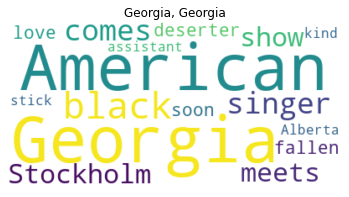

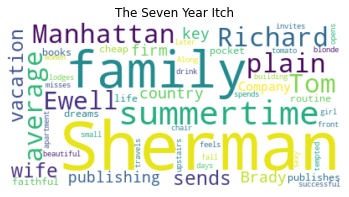

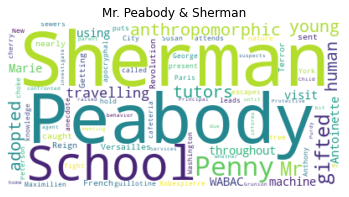

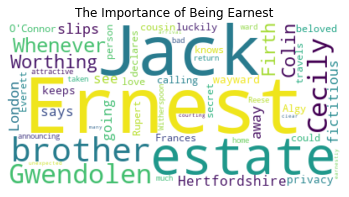

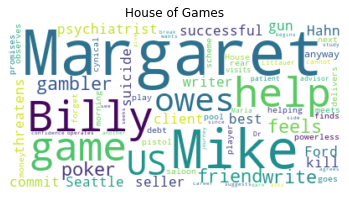

In [96]:
for i in movie_indices:
    wc = WordCloud(stopwords=stop_words,background_color='white').generate(movie_book_df2.iloc[i]['plot/book_desc'])
    plt.imshow(wc, interpolation='bilinear')
    plt.title(movie_book_df2.iloc[i]['title'])
    plt.axis("off")
    plt.show();

In [97]:
recommendation,movie_indices,idx = movie_recommendations(cos_mat,movie_book_df2,'memoirs of a geisha')
recommendation

[6752, 1326, 11046, 920, 721]


6752                  Yôkirô
1326                Nagareru
11046    Memoirs of a Geisha
920      The Woman of Rumour
721                 A Geisha
Name: title, dtype: object

In [99]:
recommendation,movie_indices,idx = movie_recommendations(cos_mat,movie_book_df2,'little women')
recommendation

[4787, 8816, 13822, 9002, 12987]


4787             Mujercitas
8816           Little Women
13822          Little Women
9002     Indradhanura Chhai
12987               4 Moons
Name: title, dtype: object